In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from tqdm import tqdm
from pathlib import Path
from uco.data_loader import pivot_df

In [4]:
N = 3698
C = 4
H = 350
W = 525

In [5]:
df = pd.read_csv('../saved/pseudo/seg/training/index.csv')
df.sort_values('score', ascending=False, inplace=True)
df.head(40)

,score,run,seed,encoder,decoder,dropout,encoder_weights,augs,img_height,img_width,batch_size,bce_weight,dice_weight,lovasz_weight,optimizer,anneal_start,anneal_end,encoder_lr,decoder_lr
42,0.664342,1117-204253,23903363,inceptionresnetv2,FPN,0.130979,imagenet,HeavyResizeTransforms,384,576,14,0.885309,0,0.114691,RAdam,1,36,0.000038,0.002924
49,0.659669,1118-032740,10037359,efficientnet-b0,FPN,0.161354,imagenet,DistortionTransforms,448,672,12,0.906143,0,0.093857,RAdam,1,26,0.000062,0.003130
43,0.659161,1117-212354,4367,inceptionv4,FPN,0.139527,imagenet,HeavyResizeTransforms,384,576,16,0.820499,0,0.179501,RAdam,1,36,0.000046,0.002524
46,0.658004,1118-000653,8317485,efficientnet-b6,FPN,0.145227,imagenet,HeavyResizeTransforms,256,384,14,0.883029,0,0.116971,RAdam,1,36,0.000057,0.003241
7,0.657816,1116-150013,4316,efficientnet-b5,FPN,0.120682,imagenet,DistortionTransforms,320,480,12,0.875956,0,0.124044,RAdam,1,36,0.000063,0.003628
45,0.657483,1117-224501,34753492,efficientnet-b0,FPN,0.151831,imagenet,CutoutTransforms,384,576,16,0.838318,0,0.161682,RAdam,1,26,0.000058,0.003158
16,0.655571,1116-210702,55304720,dpn131,FPN,0.147313,imagenet,HeavyResizeTransforms,320,480,10,0.915565,0,0.084435,RAdam,1,36,0.000037,0.002113
12,0.654659,1116-185241,10252539,efficientnet-b5,FPN,0.159216,imagenet,CutoutTransforms,320,480,12,0.875513,0,0.124487,RAdam,1,36,0.000056,0.003533
14,0.654574,1116-202613,24260688,efficientnet-b2,FPN,0.140414,imagenet,HeavyResizeTransforms,320,480,16,0.851753,0,0.148247,RAdam,1,26,0.000052,0.003863
24,0.653928,1117-052349,40547331,efficientnet-b5,FPN,0.106728,imagenet,CutoutTransforms,320,480,12,0.891508,0,0.108492,RAdam,1,36,0.000053,0.003906


In [6]:
df.groupby(['encoder', 'decoder']).agg({'score': ['mean', 'max', 'count']})  # ['score'].mean()

score                
                                mean       max count
encoder            decoder                          
densenet161        FPN      0.649459  0.652850     6
dpn131             FPN      0.648183  0.655571     5
efficientnet-b0    FPN      0.650327  0.659669    11
efficientnet-b2    FPN      0.645794  0.654574     5
efficientnet-b4    FPN      0.645018  0.647955     2
efficientnet-b5    FPN      0.651655  0.657816     6
efficientnet-b6    FPN      0.647615  0.658004     3
inceptionresnetv2  FPN      0.650748  0.664342     3
inceptionv4        FPN      0.650694  0.659161     4
resnext101_32x8d   FPN      0.641398  0.644686     7
se_resnext50_32x4d FPN      0.649538  0.652426     3

In [7]:
def read(f):
    path = Path('../data/raw/test_images') / f
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

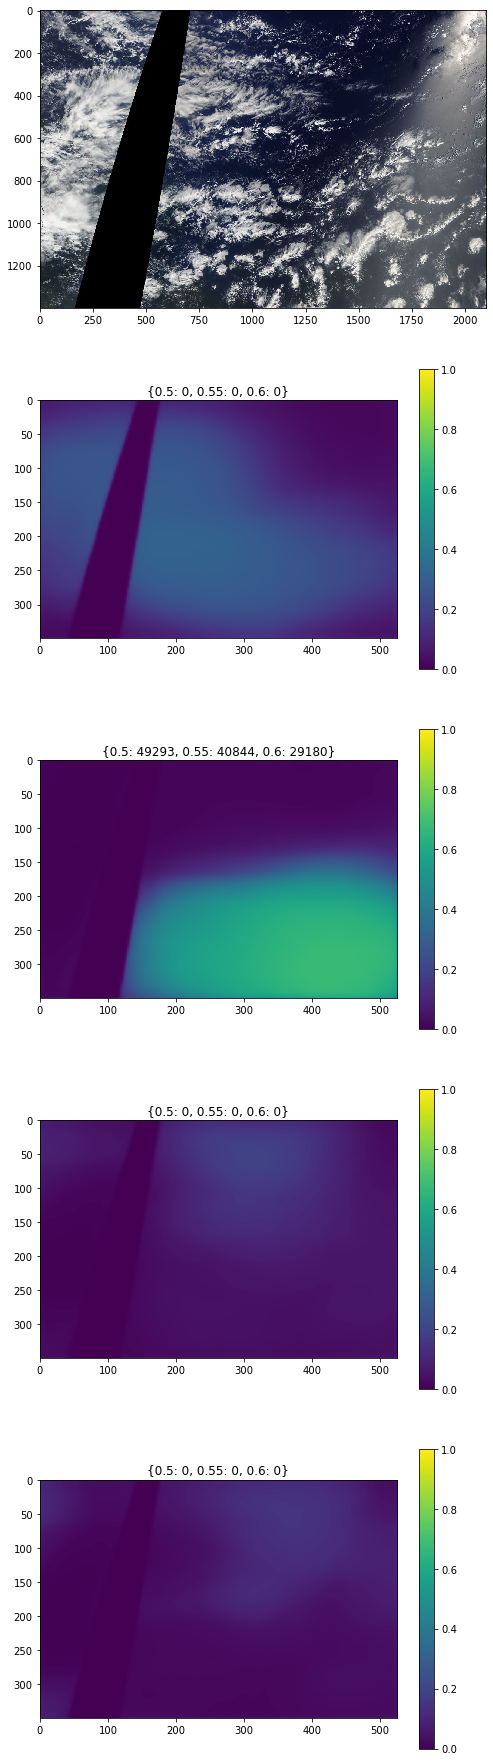

In [8]:
df = pd.read_csv('../data/raw/sample_submission.csv')
idx = np.random.choice(np.arange(df.shape[0] // 4))
with h5py.File('../data/original/avg-seg-predictions.h5', 'r') as f:
    p = f['average'][idx, :, :, :]
img_filename = df.iloc[idx * 4]['Image_Label'].split('_')[0]
img = read(img_filename)
fig, axs = plt.subplots(5, 1, figsize=(8, 32))
im0 = axs[0].imshow(img)
for c in range(4):
    counts = {th: (p[c, :, :] > th).sum() for th in [0.50, 0.55, 0.60]}
    im = axs[c+1].imshow(p[c, :, :], clim=(0, 1))
    axs[c+1].set_title(counts)
    plt.colorbar(im, ax=axs[c+1])
plt.show()

In [9]:
df.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1


In [10]:
df.loc[df['Image_Label'] == '041b654.jpg_Flower', :]

,Image_Label,EncodedPixels
237,041b654.jpg_Flower,1 1


In [11]:
if '0110417.jpg_Fish' in df['Image_Label'].values:
    print(True)

True


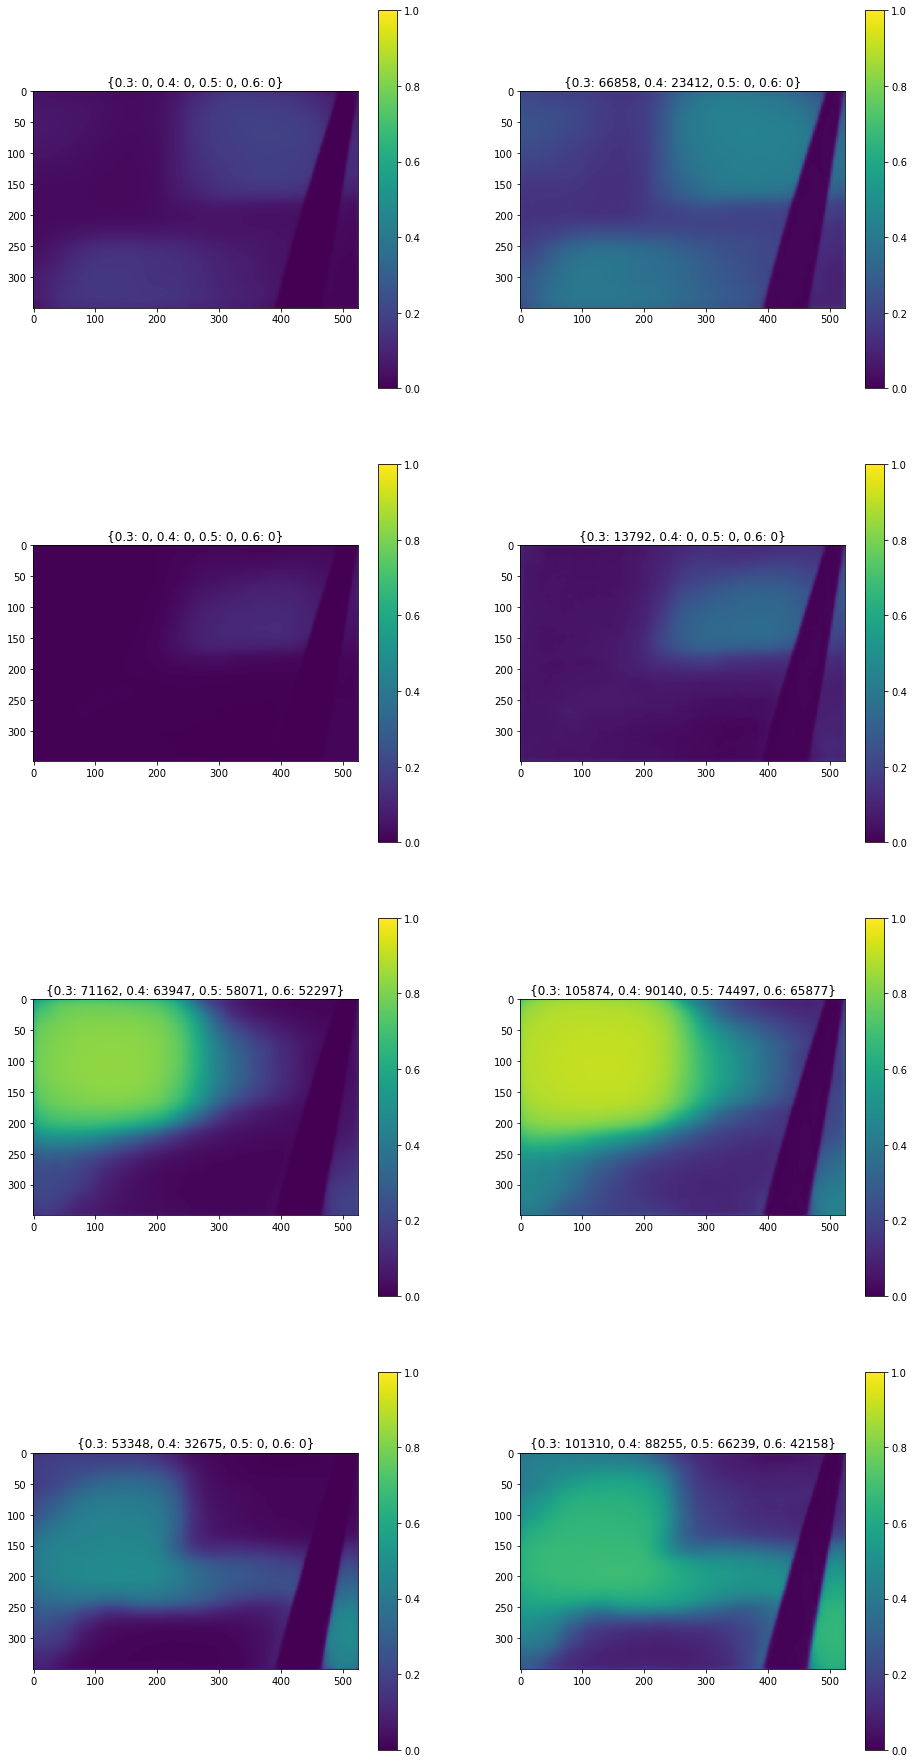

In [23]:
key = 'average'
fig, axs = plt.subplots(C, 2, figsize=(16, 32))

idx =  np.random.choice(np.arange(N))
with h5py.File('../data/original/avg-seg-predictions.h5', 'r') as f:
    p = f[key][idx, :, :, :]
    for c in range(C):
        ax = axs[c, 0]
        counts = {th: (p[c, :, :] > th).sum() for th in [0.30, 0.40, 0.50, 0.60]}
        im = ax.imshow(p[c, :, :], clim=(0, 1))
        ax.set_title(counts)
        plt.colorbar(im, ax=ax)
with h5py.File('../data/pseudo/avg-seg-predictions.h5', 'r') as f:
    p = f[key][idx, :, :, :]
    for c in range(C):
        ax = axs[c, 1]
        counts = {th: (p[c, :, :] > th).sum() for th in [0.30, 0.40, 0.50, 0.60]}
        im = ax.imshow(p[c, :, :], clim=(0, 1))
        ax.set_title(counts)
        plt.colorbar(im, ax=ax)
plt.show()

In [130]:
with h5py.File('../data/original/avg-clas-predictions.h5', 'r') as f:
    for th in np.linspace(0.4, 0.7, 30):
        counts = np.zeros((4,))
        #for k in f.keys():
        for k in ['average']:
            for n in range(N):
                counts += (f[k][n, :] > th).astype(np.uint8)
        print(f'threshold {th}: {counts}')

threshold 0.4: [2176. 1741. 2218. 2954.]
threshold 0.41034482758620694: [2129. 1726. 2163. 2925.]
threshold 0.4206896551724138: [2081. 1706. 2122. 2893.]
threshold 0.4310344827586207: [2032. 1695. 2081. 2845.]
threshold 0.4413793103448276: [1997. 1661. 2026. 2809.]
threshold 0.4517241379310345: [1952. 1645. 1966. 2777.]
threshold 0.4620689655172414: [1904. 1623. 1919. 2732.]
threshold 0.4724137931034483: [1872. 1600. 1876. 2698.]
threshold 0.4827586206896552: [1834. 1579. 1848. 2667.]
threshold 0.49310344827586206: [1808. 1560. 1807. 2640.]
threshold 0.503448275862069: [1765. 1539. 1767. 2607.]
threshold 0.5137931034482759: [1732. 1525. 1729. 2580.]
threshold 0.5241379310344827: [1687. 1514. 1691. 2545.]
threshold 0.5344827586206896: [1654. 1499. 1652. 2513.]
threshold 0.5448275862068965: [1621. 1483. 1616. 2473.]
threshold 0.5551724137931034: [1576. 1461. 1581. 2421.]
threshold 0.5655172413793104: [1535. 1440. 1552. 2384.]
threshold 0.5758620689655172: [1490. 1420. 1521. 2354.]
thresh

In [212]:
np.sort([1, 5, 3, 4])

array([1, 3, 4, 5])